# Introduction 
The aim of this project is to evaluate and develop several algorithms for classifying images of handwritten digits. The data set is the MNIST data set. This data set contains 70000 digits of size 28x28. The data is split into a training set (60000) and a test set (10000). 

# Implementation
Let's start by importing the modules that are required for this project.

In [1]:
# import
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import pandas as pd
import seaborn as sns
import operator
import tensorflow as tf
from keras.datasets import mnist
%matplotlib inline

# 1. Data loading and cleaning
In this step, the data is loaded and inspected to see if there are missing values.

In [2]:
# get the MNIST data set
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
print("Shape of training dataset: {}".format(np.shape(X_train)))
print("Shape of test dataset: {}".format(np.shape(X_test)))

Shape of training dataset: (60000, 28, 28)
Shape of test dataset: (10000, 28, 28)


The data are images representing digits, $d = 0, 1, \dots, 9$. Let's take a look at such an image. 

Label for image: 5


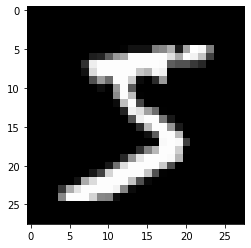

In [9]:
# visualize data 
plt.figure()
plt.imshow(X_train[0], cmap='gray')
plt.savefig('five.png')

print("Label for image: {}".format(y_train[0]))

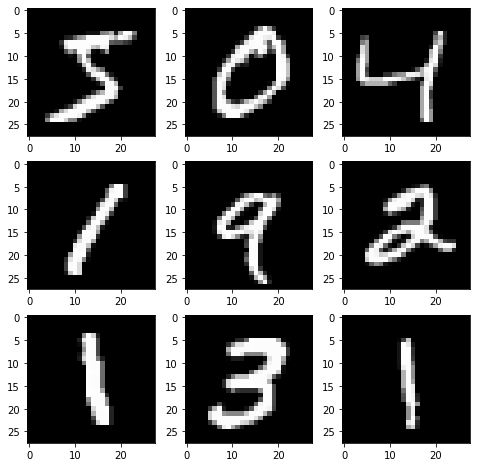

In [20]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = X_train[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
plt.savefig('nine_digits.png')
plt.show()

A $28 \times 28$ image can also be represented by a single vector of size 784. Let's transform the $28 \times 28$ images into such vectors and store them into dataframes. 

###### Transform training data

In [5]:
X_train_flat = X_train[0].flatten()
for i in range(len(X_train)-1):
    X_train_flat = np.vstack((X_train_flat, X_train[i+1].flatten()))

print("Shape of training dataset is now: {}".format(X_train_flat.shape))

# transform np.array into a dataframe
X_train_df = pd.DataFrame(X_train_flat)

# check if it corresponds to 784 vector
#sum([x for x in X_train_flat[600]] == X_train_df.iloc[600,:])

y_train_df = pd.DataFrame(y_train)
y_train_df.columns = ['digit']

Shape of training dataset is now: (60000, 784)


###### Transform test data

In [6]:
X_test_flat = X_test[0].flatten()

for i in range(len(X_test)-1):
    X_test_flat = np.vstack((X_test_flat, X_test[i+1].flatten()))

print("Shape of test dataset is now: {}".format(X_test_flat.shape))

# transform np.array into a dataframe
X_test_df = pd.DataFrame(X_test_flat)

# check if it corresponds to 784 vector
#sum([x for x in X_test_flat[600]] == X_test_df.iloc[600,:])

y_test_df = pd.DataFrame(y_test)
y_test_df.columns = ['digit']

Shape of test dataset is now: (10000, 784)


In [7]:
print(X_train_df.isnull().values.any())
print(y_train_df.isnull().values.any())
print(X_test_df.isnull().values.any())
print(y_train_df.isnull().values.any())

False
False
False
False


Great, no missing values! 

# 2. Classifiers
The goal is to develop and evaluate several algorithms for classifying the handwritten digits. 

## 2.1  Distance-based classifier

It is useful to develop some intuitions about clouds of points in highly
dimensional spaces. Let's start with developing a simple distance-based classifier. For each digit $d$, $d = 0,1,. . . ,9$, consider a cloud of points in a 784-dimensional space, $C_d$, which consists of all training images that represent $d$. For each cloud, $C_d$, let's calculate its center, $\bar{c}_d$, which is a 784-dimensional vector of means over all coordinates of vectors that belong to $C_d$. After calculating these centers, a new image will be classified by calculating the distance from the vector that represents this image to each of the 10 centers. The new image is assigned to the class for which the distance is smallest. 

### 2.1.1 Calculate center
The first step is to calculate the center, $\bar{c}_d$, for each cloud. This is done by creating a dataframe which is a concatenating of X\_train\_df and y\_train\_df. This will be a $60000 \times 785$ dataframe, where the last column is the digit represented by the vector of 784 numbers. Then, using a for loop, let's get a vector of means for each $C_d$. The 10 centers are stored into a $10 \times 784$ dataframe. This dataframe is shown in Table 1. 

In [8]:
# concatenate the dataframes
train_df = pd.concat([X_train_df, y_train_df], axis = 1)

# initialize empty dataframe to store centers
train_center = pd.DataFrame()

# get center of every cloud
for d in range(10):
    new_row = pd.DataFrame(train_df.loc[train_df.iloc[:,-1] == d, ].mean()).T
    train_center = train_center.append(new_row)
train_center = train_center.iloc[:, :-1]
train_center.index = range(10)

# the center of digit d
print("\nTable 1: The centers of digit d.")
display(train_center)


Table 1: The centers of digit d.


,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.765682,0.672785,0.258101,0.105188,0.112211,0.019154,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.162044,0.187763,0.188435,0.083712,0.034291,0.000000,0.0,0.0,0.0,0.0


### 2.1.2 Calculate radius
For each cloud $C_d$, the radius, $r_d$, is also calculated. This radius is defined as the biggest distance between the center of $C_d$ and the points of $C_d$. The radius, $r_d$, is calculated by subtracting the center, $\bar{c}_d$, from each of the points of $C_d$ and squaring this. Then, the values of each row are summed and the square root is taken over this value. By then, the result is a vector (of which the length was equal to the number of points of $C_d$) of distances. Since the radius is the biggest distance, the biggest value from this vector is extracted and stored into a dataframe. That way, the end result is a $10 \times 1$ dataframe, which can e seen in Table 2. 

In [9]:
# initialize empty list
radius = []

# get radius of every cloud
for d in range(10):
    radius.append(
        max(np.sqrt(((train_df.loc[train_df.iloc[:,-1] == d, ].iloc[:, :-1] - train_center.iloc[d,])**2).sum(axis=1)))
    )

radius = pd.Series(radius, name="Radius")

# the radius of digit d
print("\nTable 2: The radius of digit d.")
display(radius.to_frame())


Table 2: The radius of digit d.


,Radius
0,2819.601369
1,2523.827282
2,2658.157521
3,2865.013660
4,2844.438736
5,2723.871508
6,2784.468500
7,2702.731897
8,2914.569563
9,2867.739967


### 2.1.3 Count occurences
It is also important to find the number of points that belong to $C_d$, $n_i$. This can be done by counting how many times each digit, $d = 0,1,. . .,9$ occurred in y\_train\_df.

There belong 5923 number of points to number 0
There belong 6742 number of points to number 1
There belong 5958 number of points to number 2
There belong 6131 number of points to number 3
There belong 5842 number of points to number 4
There belong 5421 number of points to number 5
There belong 5918 number of points to number 6
There belong 6265 number of points to number 7
There belong 5851 number of points to number 8
There belong 5949 number of points to number 9


<AxesSubplot:xlabel='digit', ylabel='count'>

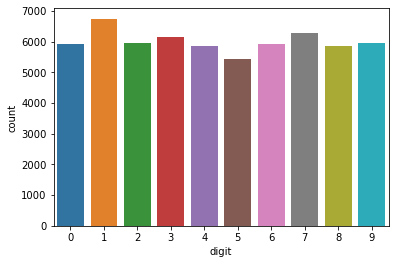

In [10]:
# counting the number of points that belong to Cd, ni
for d in range(10):
    print("There belong", sum(train_df.iloc[:,-1] == d), "number of points to number", d )

sns.countplot(x="digit", data=y_train_df)

It can be concluded that the training data is quite balanced, however not completely balanced. For example number 5 occured 5421 times and number 1, 6742 times. This could influence the classifier. However, the difference is not very big. 

### 2.1.4 Calculate distance
Next, the distances between the 10 centers, $dist_{ij} = dist(\bar{c}_i, \bar{c}_j)$, for $i, j = 0, 1, \dots, 9$, need to be calculated. Figure 1 shows a heatmap of the distances. 


Figure 1: The heatmap of the distances.


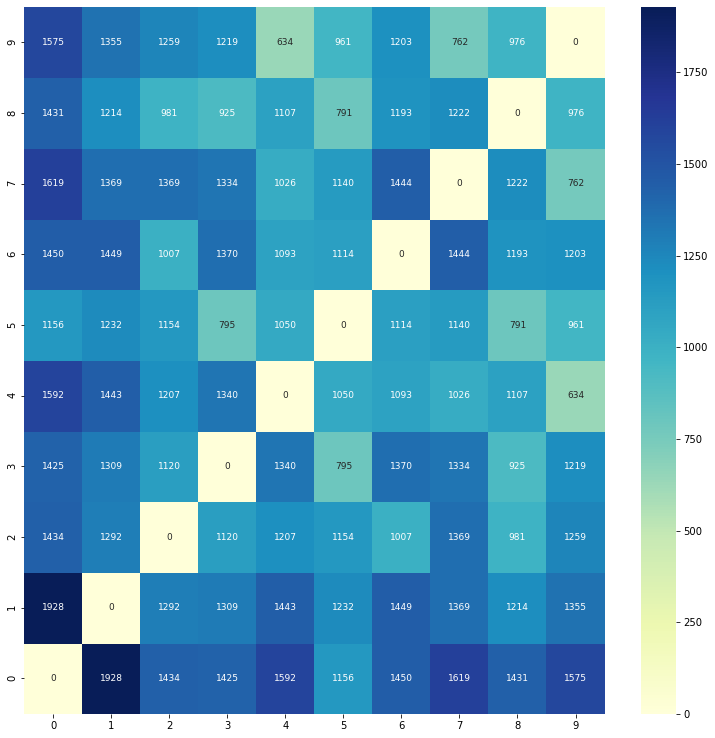

In [11]:
# calculate the distances between the centers of the 10 clouds
def find_distances(centers):
    distances = np.zeros((len(centers), len(centers)))
  
    for i in range(len(centers)):
        for j in range(len(centers)):
            distances[i,j] = np.linalg.norm(centers.iloc[i,]-centers.iloc[j,])
    return(distances)

fig, ax = plt.subplots(figsize=(13,13))      # size of figure
distances = find_distances(train_center)
distances = distances.round(0)

print("\nFigure 1: The heatmap of the distances.")
distance_heatmap = sns.heatmap(distances, annot=True, cmap="YlGnBu", cbar=True, annot_kws={"size": 9}, fmt='g')
distance_heatmap.invert_yaxis()

Figure 1 shows that some numbers seems hard to distinguish. The lighter the color of the square in Figure 1, the smaller the distance between the two digits. If the distance between two digits is small, the classifier will have trouble distinguishing these two digits. The most difficult numbers to separate will be 4 & 9. But, also the following pairs are going to be difficult to separate: 7 & 9, 3 & 5, and 5 & 8. It was mentioned earlier that the occurrence of number 5 is lower than that of the other numbers (5421 times in the training data). This could explain why the number 5 is harder to seperate from the numbers 3 and 8. 

### 2.1.5 Implement and evaluate
Let's implement the simplest distance-based classifier that was described above. This is done by making a function that predicts the digit, given the training data, X\_train\_df, and the centers, train\_center. The distance is calculated by subtracting the centers, $\bar{c}_d$, from a row in X\_train\_df and squaring this. Then, the sum of this row is taken and over this, the square root is taken. Then, the center which gives the minimum distance is the predicted digit. For example, the distance between the first row of X\_train\_df and each of the ten centers was calculated. Say, that the distance between the first row and the center of digit 4 is smallest, then the first row would be classified as a 4. This is done for the whole training set. 

In [12]:
# implement the simplest distance-based classifier
def distance_classifier(input_data, centers):
    pred = []
    for i in range(len(input_data)):
        distances_to_centers = []
        for j in range(10):
            distances_to_centers.append(sum((input_data.iloc[i,] - centers.iloc[j,])**2))
        pred.append(distances_to_centers.index(min(distances_to_centers)))
 
    return(pred)

In [13]:
# import some needed modules
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# apply classifier to all points from the training set 
predicted_vals = distance_classifier(X_train_df, train_center)

# percentage correct
print("Accuracy score:", accuracy_score(y_train_df, predicted_vals))
print("Percentage correct:", (accuracy_score(y_train_df, predicted_vals)*100).round(2))

# classification report
print(classification_report(y_train_df, predicted_vals))

Accuracy score: 0.8079833333333334
Percentage correct: 80.8
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      5923
           1       0.75      0.96      0.84      6742
           2       0.87      0.76      0.81      5958
           3       0.74      0.77      0.76      6131
           4       0.80      0.81      0.80      5842
           5       0.73      0.67      0.70      5421
           6       0.88      0.87      0.87      5918
           7       0.90      0.84      0.87      6265
           8       0.79      0.73      0.76      5851
           9       0.74      0.78      0.76      5949

    accuracy                           0.81     60000
   macro avg       0.81      0.80      0.81     60000
weighted avg       0.81      0.81      0.81     60000



The accuracy score of this classifier was $0.81$. According to the classification report, the digits 5 and 8 were the most difficult to classify. For these two digits, the column 'recall', is the lowest. 

In [14]:
# confusion_matrix
print("\nTable 3: Confusion matrix of the training data.")
pd.DataFrame(confusion_matrix(y_train_df, predicted_vals))


Table 3: Confusion matrix of the training data.


,0,1,2,3,4,5,6,7,8,9
0,5134,4,51,26,16,402,169,23,83,15
1,0,6485,49,11,3,78,9,7,94,6
2,98,359,4516,208,171,36,183,124,231,32
3,53,183,200,4721,12,365,48,64,328,157
4,11,139,30,0,4722,10,105,26,76,723
5,95,435,32,713,147,3635,111,42,64,147
6,81,213,153,4,115,189,5137,0,26,0
7,34,315,63,6,143,20,4,5267,84,329
8,48,355,76,554,65,212,48,22,4242,229
9,62,181,48,97,498,51,10,266,116,4620


As can be seen in Table 3, 0 was quite often misclassified as 5. Also, 2 was often misclasssified as 1, 3 was often misclassified as 5 or 8, 4 was often misclassified as 9, 5 was often misclassified as 1 or 3, 7 was often misclassified as 1 or 9, 8 was often misclassified as 1 or 3, 9 was often misclassified as 4. 

Now, the distance-based classifier is evaluated on the test set. 

In [15]:
# apply classifier to all points from the test set 
predicted_vals_test = distance_classifier(X_test_df, train_center)

# percentage correct
print("Accuracy score:", accuracy_score(y_test_df, predicted_vals_test))
print("Percentage correct:", (accuracy_score(y_test_df, predicted_vals_test)*100).round(2))

# classification report
print(classification_report(y_test_df, predicted_vals_test))

Accuracy score: 0.8203
Percentage correct: 82.03
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       980
           1       0.77      0.96      0.86      1135
           2       0.88      0.76      0.81      1032
           3       0.77      0.81      0.78      1010
           4       0.80      0.83      0.81       982
           5       0.75      0.69      0.72       892
           6       0.88      0.86      0.87       958
           7       0.91      0.83      0.87      1028
           8       0.79      0.74      0.76       974
           9       0.77      0.81      0.79      1009

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



For this set, the accuracy score was $0.82$. So the percentage of correctly classified digits increased from $81 \%$ to $82 \%$. 

In [16]:
# confusion_matrix
print("\nTable 4: Confusion matrix of the training data.")
pd.DataFrame(confusion_matrix(y_test_df, predicted_vals_test))


Table 4: Confusion matrix of the training data.


,0,1,2,3,4,5,6,7,8,9
0,878,0,7,2,2,58,25,1,7,0
1,0,1092,10,3,0,7,3,0,20,0
2,19,71,781,33,31,3,23,18,50,3
3,4,24,25,814,1,49,8,15,58,12
4,1,22,2,0,811,3,16,1,10,116
5,11,63,2,118,21,612,27,10,13,15
6,18,27,22,0,31,32,827,0,1,0
7,2,59,22,1,20,2,0,856,13,53
8,14,39,11,83,12,36,13,10,718,38
9,15,22,7,10,83,12,1,27,18,814


Looking at Table 4, it can be seen that, 4 was often mistaken as 9, and 5 was often mistaken as 3. 


Previously, it was stated that 4 & 9, 7 & 9, 3 & 5, and 5 & 8 would be difficult to seperate. In the case of the training set, this was true. But apparently also for 0 & 5, 2 & 1, 5 & 1, 7 & 1, 8 & 1, and 8 & 3. In the case of the test set, this was true for 4 & 9 and 5 & 3. But not for the rest. 

### 2.1.6 Using alternative distance measures
So far, the Euclidean distance was used to measure the distance between two vectors. However, this is not the only choice. Several other distance measures were used and the results are presented in the Table 5. 

In [17]:
# using alternative distance measures  
from sklearn.metrics.pairwise import pairwise_distances
  
def distance_classifier_pairwise(input_data, centers, metric):
    pred = []
    distances_to_centers = pairwise_distances(input_data, centers, metric)
    for i in range(len(distances_to_centers)):
        pred.append(distances_to_centers[i, ].argmin())
    return(pred)


In [18]:
# Euclidean
pred_eu = distance_classifier_pairwise(X_test_df, train_center, metric = "euclidean")

# Cityblock
pred_city = distance_classifier_pairwise(X_test_df, train_center, metric = 'cityblock')

# Cosine
pred_cos = distance_classifier_pairwise(X_test_df, train_center, metric = 'cosine' )

# L1
pred_l1 = distance_classifier_pairwise(X_test_df, train_center, metric = 'l1')

# L2
pred_l2 = distance_classifier_pairwise(X_test_df, train_center, metric = 'l2')

# Manhattan
pred_manhattan = distance_classifier_pairwise(X_test_df, train_center, metric = 'manhattan')


data = {'Accuracy score':[accuracy_score(y_test_df, pred_eu),
                          accuracy_score(y_test_df, pred_city),
                          accuracy_score(y_test_df, pred_cos),
                          accuracy_score(y_test_df, pred_l1),
                          accuracy_score(y_test_df, pred_l2),
                          accuracy_score(y_test_df, pred_manhattan)]}
acc_distances_df = pd.DataFrame(data, index=['Euclidean','Cityblock','Cosine','L1', 'L2', 'Manhattan'])

print('\nTable 5: The accuracy scores using alternative distance measures.')
display(acc_distances_df)


Table 5: The accuracy scores using alternative distance measures.


,Accuracy score
Euclidean,0.8203
Cityblock,0.6685
Cosine,0.8216
L1,0.6685
L2,0.8203
Manhattan,0.6685


As can be seen in Table 5, the Cosine distance measure gives the highest result, namely an accuracy score of $0.8216$. The distance measures Cityblock, L1, and Manhattan give the same result, but also the lowest result with an accuracy score of $0.6685$. The distance measures Euclidean and L2 are in between these result, with an accuracy score of $0.8203$. However, the difference between those measures and Cosine is not that big. 

## 2.2 Bayes Rule classifier
To keep things simple, only the digits 1 and 6 are considered from now on. First, it is important to decide which feature to use to discriminate between these two digits. Let's use the width of the digit as a discriminative feature. The second step is to implement this feature and to apply it to the training set, discretize it, and create corresponding histograms. 

### 2.2.1 Implement Bayes rule
A function is created that would classify digits according to Bayes rule. The function first makes a subset of the input data, so that the data set would only contain the images of 1's and 6's. Then, the width of the 1's and 6's is calculated in to order to obtain $P(X = x \vert C = 1)$ and $P(X = x \vert C = 6)$. As described before, a digit is represented by a vector of 784 numbers, that represent a $28 \times 28$ image. So, in order to get the width of an image, the vector is transformed back into a $28 \times 28$ dataframe. For each row, it is counted how many numbers are not equal to 0.000, because 0.000 would be equal to a black pixel. Thus, for every image, there are 28 'widths' and the row with the biggest width, would be the actual width of the image. The maximum width is 28, since there are 28 columns. This implies that the width could range between 1 and 28. 

This function is able to calculate $P(X=x \vert C = 1)$ and $P(X = x \vert C = 6)$. More specifically, $P(X = x \vert C = 1) = \frac{\text{number of samples in corresponding box}}{\text{number of samples in C = 1 row}}$. Next, $P(C = 1) = \frac{\text{number of samples in row C = 1}}{\text{total number of samples}}$ and $P(C = 6)=\frac{\text{number of samples in row C = 6}}{\text{total number of samples}}$ are calculated. Then, by Bayes rule, $P(C \vert X = x) = P(X = x \vert C)P(C)$ can be calculated. Subsequently, $y_1(x) = P(X = x \vert C = 1)P(C = 1)$ and $y_2(x) = P(X = x \vert C = 6)P(C = 6)$ is calculated and $y(x) = y_1(x) - y_2(x)$ is used as a discriminant. If $y(x) > 0$ then the digit was predicted to be a 1, otherwise the digit was predicted to be a 6. 

In [19]:
def Bayes(data_in, data_out):
    
    pred = []
    import operator
    data_in_out = pd.concat([data_in, data_out], axis = 1)
    data_out_subset = data_out.loc[operator.or_(data_out.iloc[:, -1] == 6, data_out.iloc[:, -1] == 1)]
    data_out_subset.index = range(len(data_out_subset))
    data_in_subset = data_in_out.loc[operator.or_(data_in_out.iloc[:, -1] == 6, data_in_out.iloc[:, -1] == 1)]
    
    train_in_subset = data_in_out.loc[operator.or_(data_in_out.iloc[:, -1] == 6, data_in_out.iloc[:, -1] == 1)]
    total = pd.DataFrame(train_in_subset)
    widths_all = pd.DataFrame(index = range(1,(len(total)+1)),columns=['1', '6'])
    
    for j in range(len(total)):
        if total.iloc[j,-1] == 1:
            data_row = total.iloc[j, :-1]
            data_mat = pd.DataFrame(data_row.values.reshape(28,28))
            width = []
            for i in range(28):
                width.append(sum(data_mat.loc[i, :] != 0))
            widths_all.iloc[j,0] = max(width)
        else:
            data_row = total.iloc[j, :-1]
            data_mat = pd.DataFrame(data_row.values.reshape(28,28))
            width = []
            for i in range(28):
                width.append(sum(data_mat.loc[i, :] != 0))
                widths_all.iloc[j,1] = max(width)
    
    bins = pd.DataFrame(index = range(1, 29), columns = ['1', '6'])
    for i in range(1, 29):
        bins.loc[i, '1'] = sum(widths_all.iloc[:,0]==i)
        bins.loc[i, '6'] = sum(widths_all.iloc[:,1]==i)
    
    prob_x_one_six = pd.DataFrame(index = range(1, 29), columns = ['1', '6'])
    for i in range(1, 29):
        prob_x_one_six.loc[i,'1'] = bins.loc[i, '1']/sum(bins.iloc[:,0])
        prob_x_one_six.loc[i,'6'] = bins.loc[i, '6']/sum(bins.iloc[:,1])
    
    widths_total = pd.DataFrame(widths_all['1'].fillna(widths_all['6']))
    widths_total.index = range(len(total))
    
    p_one = sum(bins.iloc[:,0])/(sum(bins.iloc[:,0])+sum(bins.iloc[:,1]))
    p_six = sum(bins.iloc[:,1])/(sum(bins.iloc[:,0])+sum(bins.iloc[:,1]))
    for i in widths_total.values:
        y_1 = float(prob_x_one_six.loc[i,'1'])*p_one
        y_2 = float(prob_x_one_six.loc[i,'6'])*p_six
        if y_1 - y_2 > 0:
            pred.append(1)
        else:
            pred.append(6)

    output = pd.concat([pd.DataFrame(data_out_subset), pd.DataFrame(pred), pd.DataFrame(widths_total)], axis = 1)
    prob = []
    for i in range(len(total)):
        if output.iloc[i, 1] == 1:
            prob.append(float(prob_x_one_six.loc[widths_total.values[i],'1'])*p_one)
        else:
            prob.append(float(prob_x_one_six.loc[widths_total.values[i],'6'])*p_six)
            
    output = pd.concat([pd.DataFrame(data_out_subset), pd.DataFrame(pred), pd.DataFrame(widths_total), pd.DataFrame(prob)], axis = 1)
    output.columns = ["True number", "Prediction", "Width", "Probability"]
    return(output)

### 2.2.2 Evaluate
The classifier will be evaluated on the training set first and after that, on the test set.  

In [20]:
# apply the classifier to the training data
bayes_train = Bayes(X_train_df, y_train_df)

# first ten rows of the output of the Bayes function
bayes_train.iloc[0:10,:]

,True number,Prediction,Width,Probability
0,1,1,6,0.117852
1,1,1,6,0.117852
2,1,1,4,0.129463
3,6,6,15,0.047630
4,1,1,4,0.129463
5,6,6,9,0.017536
6,1,1,6,0.117852
7,1,6,16,0.047235
8,6,6,12,0.065324
9,6,6,13,0.062796


In [21]:
# running Bayes classifier on training data
pred_vals_one_six = bayes_train.iloc[:,1]
y_train_df_subset = y_train_df.loc[operator.or_(y_train_df.iloc[:, -1] == 6, y_train_df.iloc[:, -1] == 1)]
y_train_df_subset.index = range(len(pred_vals_one_six))

# percentage correct
print("Accuracy score:", accuracy_score(y_train_df_subset, pred_vals_one_six))
print("Percentage correct:", (accuracy_score(y_train_df_subset, pred_vals_one_six)*100).round(2))

# classification report
print(classification_report(y_train_df_subset, pred_vals_one_six))

Accuracy score: 0.9631911532385466
Percentage correct: 96.32
              precision    recall  f1-score   support

           1       0.98      0.95      0.97      6742
           6       0.95      0.97      0.96      5918

    accuracy                           0.96     12660
   macro avg       0.96      0.96      0.96     12660
weighted avg       0.96      0.96      0.96     12660



The accuracy score of this classifier was $0.96$. 

In [22]:
# confusion_matrix 
print("\nTable 6: Confusion matrix of the training data.")
pd.DataFrame(confusion_matrix(y_train_df_subset, pred_vals_one_six), index = [1,6], columns = [1,6])


Table 6: Confusion matrix of the training data.


,1,6
1,6426,316
6,150,5768


In [23]:
# apply the classifier to the test data
bayes_test = Bayes(X_test_df, y_test_df)

# first ten rows of the output of the Bayes function
bayes_test.iloc[0:10,:]

,True number,Prediction,Width,Probability
0,1,1,4,0.132824
1,1,1,5,0.166269
2,6,6,14,0.063067
3,1,1,5,0.166269
4,6,6,12,0.061156
5,6,6,12,0.061156
6,1,1,4,0.132824
7,1,1,4,0.132824
8,1,1,5,0.166269
9,1,1,6,0.127090


In [24]:
# running Bayes classifier on test data
pred_vals_one_six_test = bayes_test.iloc[:,1]
y_test_df_subset = y_test_df.loc[operator.or_(y_test_df.iloc[:, -1] == 6, y_test_df.iloc[:, -1] == 1)]
y_test_df_subset.index = range(len(pred_vals_one_six_test))

# percentage correct
print("Accuracy score:", accuracy_score(y_test_df_subset, pred_vals_one_six_test))
print("Percentage correct:", (accuracy_score(y_test_df_subset, pred_vals_one_six_test)*100).round(2))

# classification report
print(classification_report(y_test_df_subset, pred_vals_one_six_test))

Accuracy score: 0.9737219302436694
Percentage correct: 97.37
              precision    recall  f1-score   support

           1       0.98      0.97      0.98      1135
           6       0.96      0.98      0.97       958

    accuracy                           0.97      2093
   macro avg       0.97      0.97      0.97      2093
weighted avg       0.97      0.97      0.97      2093



The accuracy score of this classifier was $0.97$. 

In [25]:
# confusion_matrix 
print("\nTable 7: Confusion matrix of the test data.")
pd.DataFrame(confusion_matrix(y_test_df_subset, pred_vals_one_six_test), index = [1,6], columns = [1,6])


Table 7: Confusion matrix of the test data.


,1,6
1,1097,38
6,17,941


Applying the Bayes classifier to the test set, resulted in an accuracy score of $0.97$. Thus, it can be concluded that the classifier did quite well. Using width as a discriminative feature, the digits 1 and 6 can be distinguished with an accuracy of $0.97$. 

## 2.3 The Multi-class Perceptron Classifier
A multi-class perceptron classifier is a single layer perceptron classifier. The idea is to construct a function that, given a new data point, will correctly predict the class to which the new data point belongs. A multi-class perceptron classifier can be made by usin multiple binary class classifiers trained with the 1 vs. all strategy.

\begin{align*}
\hat{y} = \text{arg} \max_{y \in \{1, \dots, 9\}} w^y x_i \\
\end{align*}

Here, $\hat{y}$ is the predicted digit, $w^y$ are the weights, and $x_i$ is the image. If the predicted digit is not the same as the actual digit, the weights need to be updated:

\begin{align*}
\text{if } \hat{y} \neq y_i:\\
w^y = w^y + \eta x_i\\
w^{\hat{y}} = w^{\hat{y}} - \eta x_i
\end{align*}

Here, $\eta$ is the step size or learning rate. Let's start by creating a $10 \times 785$ weights matrix of ones and a $60000 \times 1$ bias row vector of ones. Next, the X\_train\_df and bias vector are concatenated (the transpose of this matrix is used, in order for the matrix multiplication to work later on). The output of the perceptron on an input $x_i$, is the dot product of two vectors ($x_i$ and the weights vector). To find the output node with the strongest activation (that is, the predicted digit), the maximum value of the dot product is chosen. If the predicted value is not equal to the true value, the weights need to be updated. For a specific amount of iterations and for every image in the training set, it is checked whether the output of the network is equal to the actual label of the digit. 

In [26]:
weights = np.ones([10,785])
bias = np.ones(len(X_train_df))
input_datframe = pd.concat([pd.DataFrame(X_train_df), pd.DataFrame(bias)], axis = 1)
input_datframe = input_datframe.T
stepsize = 0.1
correct = []

In [27]:
# training set
iterations = 100
for i in range(iterations):
    correct = []
    for j in range(input_datframe.shape[1]):
        true = int(y_train_df.iloc[j])
        output = np.dot(weights, input_datframe.iloc[:, j])
        pred = int(output.argmax())
        if (pred == true):
            correct.append(1)
        else:
            weights[pred, :] -= stepsize*input_datframe.iloc[:, j]
            weights[true, :] += stepsize*input_datframe.iloc[:, j]
print("Correct:", sum(correct))
print("Accuracy/succes:", sum(correct)/input_datframe.shape[1] )

Correct: 53901
Accuracy/succes: 0.89835


After iterating through the training set, the classifier is trained and can be fitted on the test set. 

In [28]:
bias = np.ones(len(X_test_df))
input_datframe = pd.concat([pd.DataFrame(X_test_df), pd.DataFrame(bias)], axis = 1)
input_datframe = input_datframe.T
stepsize = 0.1
correct = []

In [29]:
# testing set
for i in range(input_datframe.shape[1]):
    true = y_test_df.iloc[i, 0]
    output = np.dot(weights, input_datframe.iloc[:, i])
    pred = int(output.argmax())
    if (pred == true):
        correct.append(1)

print("Correct:", sum(correct))
print("Accuracy/succes:", sum(correct)/input_datframe.shape[1] )

Correct: 8633
Accuracy/succes: 0.8633


After running our algorithm on the test set, we have achieved an accuracy score of $0.863$.

# Conclusion
Three different classifiers were evaluated in this project. Their accuracy in predicting handwritten digits on the test set was evaluated. The results can be found Table 8, below. It turns out that the Bayes' rule classifier achieves the highest accuracy, that is 0.97. 

In [30]:
conclus = {'Accuracy score':[accuracy_score(y_test_df, predicted_vals_test),
                             accuracy_score(y_test_df_subset, pred_vals_one_six_test),
                             sum(correct)/input_datframe.shape[1]]}
conclus_df = pd.DataFrame(conclus, index=['Distance-based classifier',"Bayes' rule classifier",'Multi-class perceptron'])

print('\nTable 8: The accuracy scores of the three different classifiers.')
display(conclus_df)


Table 8: The accuracy scores of the three different classifiers.


,Accuracy score
Distance-based classifier,0.820300
Bayes' rule classifier,0.973722
Multi-class perceptron,0.863300
